In [8]:
def evaluate(model, batch):
    # 0) Convert to Gray
    def rgb_to_gray(x):
        weights = torch.tensor([0.2989, 0.5870, 0.1140], dtype=x.dtype, device=x.device)
        gray = (x * weights[None, None, :, None, None]).sum(dim=2)
        return gray # -- shape: [B, T, H, W]
    
    video_L = rgb_to_gray(batch["img"][:, :, 0]) # ~ (b, t, h, w)
    video_R = rgb_to_gray(batch["img"][:, :, 1]) # ~ (b, t, h, w)
    
    # 1) Extract and normalize input videos.
    # -- min_max_norm = lambda x : 2. * (x / 255.) - 1.
    min_max_norm = lambda x: x / 255.
    video_L = min_max_norm(video_L) # ~ (b, t, h, w)
    video_R = min_max_norm(video_R) # ~ (b, t, h, w)
    
    # 2) If the tensor is non-contiguous and we try .view() later, PyTorch will raise an error:
    video_L = video_L.contiguous()
    video_R = video_R.contiguous()
    
    # 3) Coded exposure modeling.
    snapshot_L = model.sci_enc_L(video_L) # ~ (b, c, h, w) -- c=2 for 2 taps
    snapshot_R = model.sci_enc_R(video_R) # ~ (b, c, h, w) -- c=2 for 2 taps
    
    # 4) Dynamic Stereo
    output = {}
    
    disparities = model.stereo(
        snapshot_L,
        snapshot_R,
        iters=10,
        test_mode=False
    )
    
    return disparities

In [9]:
import sys
import torch

sys.path.append("../")

import datasets.dynamic_stereo_datasets as datasets
from train import wrapper

model = wrapper(sigma_range=[0, 1e-9],
                num_frames=8,
                in_channels=1,
                n_taps=2,
                resolution=[480, 640],
                mixed_precision=True,
                attention_type="self_stereo_temporal_update_time_update_space",
                update_block_3d=True,
                different_update_blocks=True,
                train_iters=10)

ckpt_path = "../dynamicstereo_sf_dr/model_dynamic-stereo_011500.pth"
state_dict = torch.load(ckpt_path)
model.load_state_dict(state_dict["model"], strict=True)

for seq_name in ["teddy_static", "ignacio_waving", "nikita_reading"]:
    real_dataset = datasets.DynamicReplicaDataset(split="test",
                                                  sample_len=8,
                                                  root="../dynamic_replica_data/real/{}".format(seq_name),
                                                  only_first_n_samples=1)
    break

for batch in real_dataset:
    batch["img"] = batch["img"].view(1, *batch["img"].shape)
    disparities = evaluate(model, batch)

seq_len teddy2_sample_new 218
Added 1 from Dynamic Replica test


In [11]:
disparities.shape

torch.Size([20, 8, 1, 1, 480, 640])

In [66]:
print (eval_dataloader_dr[0]["valid_disp"].shape)

torch.Size([8, 2, 720, 1280])


torch.Size([8, 2, 720, 1280])
torch.Size([8, 1, 720, 1280])


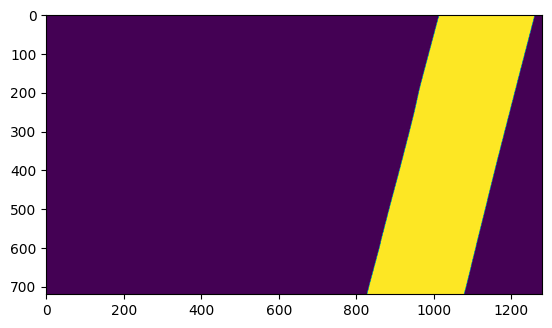

In [51]:
import matplotlib.pyplot as plt
import numpy as np

print (dataloader[0]["valid_disp"].shape)
print (dataloader[0]["valid_disp"][:, :1].shape)

img_rgb = dataloader[0]["img"][0,1].permute(1,2,0).cpu().numpy().astype('uint8')
plt.imshow(dataloader[0]["valid_disp"][0, 1])
plt.show()


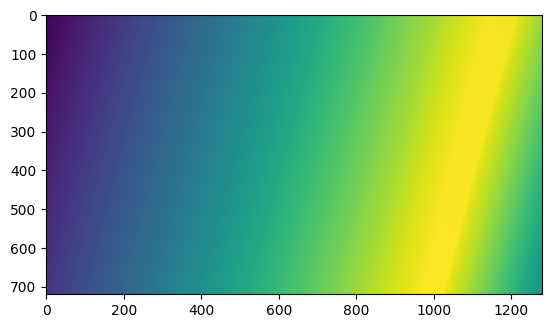

In [42]:
plt.imshow(dataloader[0]["disp"][1, 1, 0])
plt.show()

93
torch.Size([8, 2, 3, 720, 1280])
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 

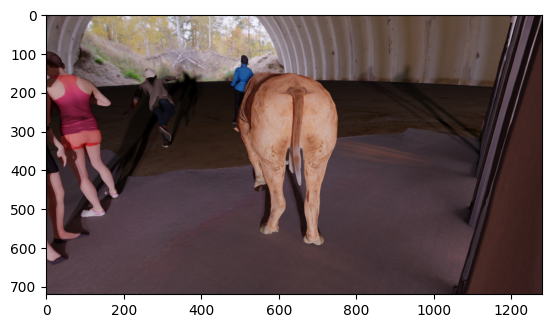

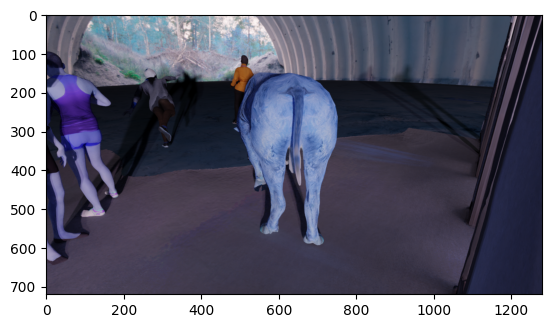

In [37]:
import numpy as np

print (len(dataloader))
print (dataloader[0]["img"].shape)
print (np.unique(dataloader[0]["img"]))
# -- print (dataloader[0]["img"][1:30, 0].shape)

img = dataloader[0]["img"][0, 0]  # (3, H, W)
R = img[0]
G = img[1]
B = img[2]

import matplotlib.pyplot as plt
img_rgb = dataloader[0]["img"][0,0].permute(1,2,0).cpu().numpy().astype('uint8')
plt.imshow(img_rgb); plt.show()

img_bgr_to_rgb = dataloader[0]["img"][0,0][[2,1,0]].permute(1,2,0).cpu().numpy().astype('uint8')
plt.imshow(img_bgr_to_rgb)
plt.show()
